<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [252]:
%%capture
pip install pyswarms

In [253]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [254]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [255]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [256]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [257]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [258]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [259]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [260]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [261]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [262]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [263]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [264]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


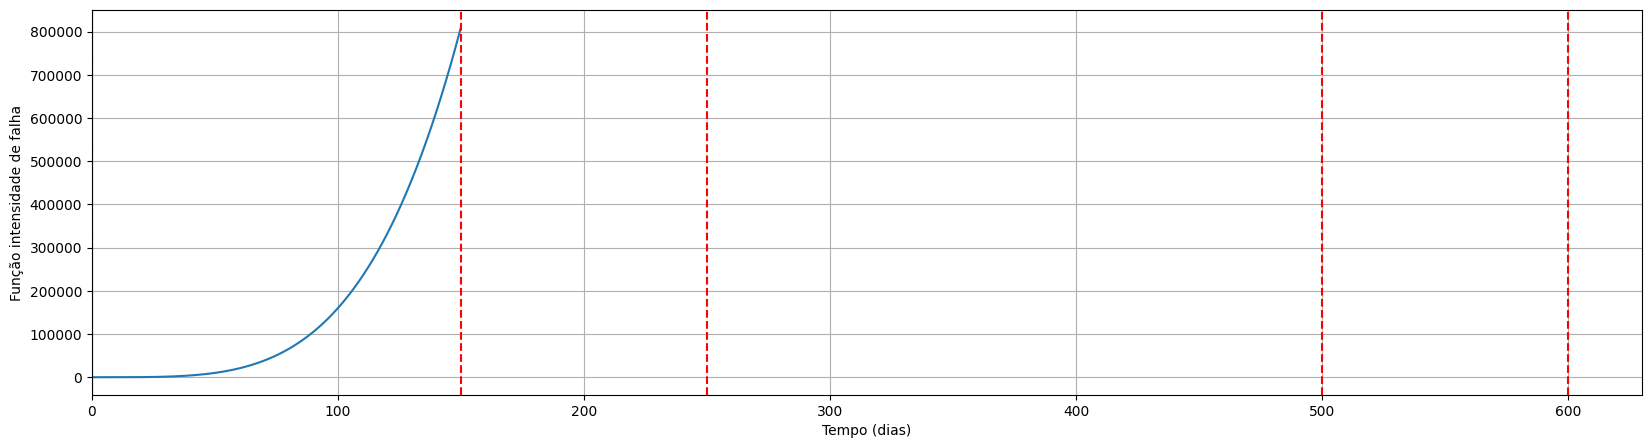

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [265]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [266]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [270]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-08-31 22:11:41,518 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   7%|▋         |7/100, best_cost=3.8e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 20, 122, 230, 269, 289, 360, 427, 538, 644]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 6551762.711345705, 33218733.580433395, 41066412.81395181, 45652821.81516881, 59904324.76154812, 81044717.11988494, 198041077.622252, 378913035.7876718, 1263608550.80754]
Custo =  57222020863.98897


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 74, 131, 178, 227, 287, 313, 377, 408, 616]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.776869

pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=3.8e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 156, 219, 281, 345, 410, 524, 541, 586, 652, 660]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 29564665.528320003, 67843075.74696109, 73113514.93613715, 111369086.58565485, 128966285.1271752, 244144314.1851787, 250936538.26802298, 282723185.3268509, 364849390.26622677, 410137828.0740417, 1098384366.487813]
Custo =  82417275770.87955


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 15, 151, 277, 364, 394, 450, 523, 574, 621, 655, 684, 713]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:

pyswarms.single.global_best:  30%|███       |30/100, best_cost=3.8e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 56, 82, 119, 146, 174, 285, 435, 467, 530, 563, 622, 655]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 176234.16832000003, 483754.8758820095, 1957222.070692942, 4400886.468985746, 5423416.949090708, 57617941.6922597, 199542881.2783727, 208244897.92365086, 388722275.3412139, 406657799.3327197, 2217248312.4175134, 2248644873.3271656, 2996366648.6657133]
Custo =  187549517415.18872


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 58, 83, 170, 240, 284, 405, 431, 511, 593, 611]
Severidade para cada subsistema: [0.25, 0.

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=3.8e+10

[0, 29, 58, 78, 169, 284, 364, 464, 480, 535, 557, 621, 718]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 6563.56768, 91012.49422092625, 237457.40436071696, 16357640.402791336, 168506204.0366835, 187562426.64673653, 248973664.66840744, 252975805.07883245, 411181457.2192969, 421496215.004897, 2365975725.738996, 2581739731.132476, 2684085206.289297]
Custo =  188376233472.27127


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 76, 118, 122, 170, 283, 319, 449, 530, 566, 588, 625, 643]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Si

pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=3.8e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 29, 56, 115, 160, 259, 287, 309, 400, 511, 561, 593, 626, 648, 671, 701]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 6563.56768, 74791.09976465875, 2282427.442729001, 8121071.097405819, 39265396.75741825, 40546262.99056796, 41710361.177990876, 74710906.55311339, 1574974058.5803516, 2592998949.512639, 3421141296.0560436, 3447674888.2903924, 3567492304.4517827, 3711587926.6923485, 3938717837.6597815, 3978882350.249476]
Custo =  328691770666.29095


Número de ciclos de m

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=3.53e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 23, 74, 115, 164, 284, 321, 551, 612, 719]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 415359.48835025326, 1852250.0862657402, 8880703.749882547, 69651161.68386503, 72583644.46436125, 870866931.5805218, 929266804.4248768, 1188318382.3944488, 1201689626.2255547]
Custo =  35348548164.97507


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 71, 114, 148, 155, 252, 284, 418, 529, 554, 593, 615, 714]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.393469340287

pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=3.53e+10

Custo =  203347929760.76733


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 17, 69, 110, 157, 268, 287, 309, 434, 480, 527, 601, 652, 661, 701]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 328065.4490907418, 1536173.2308009462, 7198733.912181058, 50791627.41049761, 51519125.96897585, 93108824.74417782, 180425056.20335743, 680851747.0054984, 704151861.4053123, 779563078.6318595, 1087761847.367297, 1095061247.954925, 1405592295.953306, 1445756808.5430005]
Custo =  126289354412.97815


Número de ciclos de manutenção: 15 5
T

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 77, 111, 159, 245, 287, 333, 461, 531, 556, 594, 601, 637, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2059.6297600000003, 517591.7434240274, 1541947.3228609508, 7627109.18200596, 27562937.363927566, 30107792.47250558, 144155321.56802964, 251861884.60982662, 297569226.8545329, 309557441.13185686, 463573701.2920611, 467414754.8834056, 657788181.8098544, 693471239.5829595, 1256576539.9753497]
Custo =  101583108647.13843


Número de ciclos de manutenção: 14 5
Tempos para manutenções prev

pyswarms.single.global_best:  71%|███████   |71/100, best_cost=3.53e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 25, 73, 106, 122, 160, 257, 287, 304, 378, 415, 462, 517, 657, 678, 708]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 3125.0000000000005, 367134.6224112817, 1194529.152811498, 1910884.1090834546, 3104114.7025286984, 32310939.11790426, 33739280.8691408, 34513067.909457855, 52419539.79691621, 59472052.544753835, 74258739.60147576, 102128562.78954622, 5275220704.849299, 5411616438.387217, 5647784059.744201, 6973855543.430935]
Custo =  453404121837.26764


Número de ciclos

pyswarms.single.global_best:  80%|████████  |80/100, best_cost=3.53e+10

Custo =  205358225311.7843


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 25, 71, 109, 143, 164, 243, 284, 381, 429, 475, 569, 661, 696]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 3125.0000000000005, 314228.9334169871, 1387000.5169191994, 4200781.869954145, 4763265.258216076, 21311282.49938818, 23666308.873617228, 57282428.757503614, 69184879.29204926, 84908841.5509507, 481345417.45267045, 4021300422.1785183, 4063731369.6023493, 6092964352.016366]
Custo =  419754959617.6007


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 24, 73, 10

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=3.53e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 24, 73, 104, 141, 162, 264, 285, 308, 369, 396, 475, 511, 565, 658, 702]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2548.0396800000003, 376007.22535727086, 1095042.080025943, 3988151.694394434, 4525530.284983096, 39547147.17485804, 40362634.780218184, 41587754.23512584, 52853016.56741325, 56641944.97030468, 96933229.80633532, 177815082.81575215, 368215075.25999844, 3879706710.266011, 3938834900.3346915, 4186263378.502079]
Custo =  220465394736.68555


Número de ciclos

pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=3.53e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 72, 118, 153, 286, 390, 442, 476, 534, 555, 599, 614, 630, 713]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 374619.44732198236, 2178995.076713987, 5976897.39073013, 83552737.20506693, 125803987.54810092, 140823971.57562143, 198443584.1754613, 1159717194.0972047, 1580632215.474243, 1768341366.628061, 1777923049.9955542, 2314498569.0808144, 2475680026.678342, 2622236835.7708993]
Custo =  354997018625.412


Número de ciclos de manutenção: 12 5
Tempos para manutenções preve

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.53e+10
2023-08-31 22:11:44,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.64366975 2.11414269 1.36554513 3.4010263  3.58475344 5.00784983
 2.13858528 2.37681329 5.82285832 5.68179933 5.75925271 4.6291728
 4.82046328 1.78795442 6.5521397  3.04512061 5.00493837 0.69416084
 6.19079041 6.97698535 4.8368456  2.89643461 3.46197213 5.15554984]
2023-08-31 22:11:44,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 19, 72, 114, 154, 284, 398, 425, 455, 520, 554, 595, 608, 646, 669, 708]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 393482.89411421726, 1819381.1394654457, 6269946.6275294125, 78581834.42020084, 134429206.77849084, 139326740.01268393, 181338994.36716783, 218864277.27955896, 886421327.5987153, 1953245720.563838, 1961103284.5721114, 3342390845.2018995, 3364221902.015072, 3678149922.320898, 3869920290.846883]
Custo =  414726390220.47363


Número de ci

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,305 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.63894696 2.11136244 1.35679148 3.38872306 3.39468242 5.01728259
 2.14160982 2.37584339 2.6168335  5.70271089 5.76025098 4.62487813
 3.9950342  1.7877303  6.55466524 2.46446871 5.00293718 0.69690411
 6.19735725 4.2890912  4.8319559  2.89646448 3.46457447 5.16174509]
2023-08-31 22:11:44,309 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 71, 114, 125, 157, 251, 287, 517, 647, 660, 707]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1649.16224, 338286.5054673387, 1801842.2485574824, 2354169.6655237377, 3211373.0460632676, 28762665.004366934, 30696052.48498806, 3426666456.667095, 3704676007.6642275, 3779135498.6053715, 4163216136.268354, 4193694168.6629624]
Custo =  130287383540.32794


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,361 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.64146063 2.11111513 1.36143679 3.389253   3.49890015 5.01344681
 2.14369133 2.37864334 1.37023573 5.70107631 5.76206417 4.62683546
 1.68196829 1.793147   6.55406351 2.07480423 5.00543215 0.69911856
 6.19781481 4.71960745 4.83790692 2.89645626 3.46547365 5.16439701]
2023-08-31 22:11:44,363 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 71, 109, 136, 157, 289, 302, 396, 642, 687, 704]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 330020.3637296402, 1402791.9472318524, 3238259.7098107687, 3716582.78402297, 82240834.73265941, 82777803.39541323, 117365602.20762302, 1452910520.4010582, 1780177053.1054416, 1907117769.264147, 3469013844.49276]
Custo =  325486853944.31635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.6437447  2.11123006 1.36653274 3.39081925 3.61780028 5.00945624
 2.14451814 2.38096762 6.88183652 5.69433842 5.76285297 4.62908083
 6.62296756 1.79771429 6.55338183 1.81494091 5.00763702 0.70097135
 6.19671682 3.91940472 4.84323449 2.89644731 3.46530358 5.16490349]
2023-08-31 22:11:44,387 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 72, 104, 145, 156, 290, 396, 480, 637, 678, 699]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 356728.80086002883, 1099820.0213857815, 4688373.568461686, 4903061.28350262, 86878348.97488531, 132904447.23819382, 179858242.69298202, 5294088697.185474, 5341442564.006504, 5495303563.546058, 5538880807.291498]
Custo =  176818605374.72455


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.64577901 2.11156246 1.37093689 3.39379981 3.7164229  5.00544951
 2.14437712 2.38243092 4.6160652  5.68710524 5.7633503  4.63111607
 3.98680577 1.80115096 6.55261943 1.73289759 5.00955644 0.70070288
 6.19462178 2.52629723 4.8471193  2.89643764 3.46450432 5.16383504]
2023-08-31 22:11:44,431 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 24, 72, 100, 154, 259, 292, 415, 480, 525, 630, 687, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 2548.0396800000003, 348160.7134079641, 902458.3264756947, 6979626.984525452, 42117256.541691236, 43885029.70955908, 118969409.84097783, 147902040.30369812, 169443761.89456835, 335492556.4258429, 763997875.8663726, 812295025.007547, 2957511202.6186824]
Custo =  310600425928.4508


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.64700751 2.11238134 1.37432255 3.39747302 3.80394403 5.0025559
 2.14283718 2.38232253 2.00487385 5.67949927 5.76319615 4.63267375
 0.93959749 1.80289904 6.55193216 1.89297182 5.01016236 0.69886632
 6.19236775 1.12749916 4.84980472 2.89642847 3.46365046 5.16279676]
2023-08-31 22:11:44,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 71, 96, 152, 264, 293, 300, 425, 474, 480, 591]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 330020.3637296402, 750069.5342255579, 6758793.004347607, 49303928.80727546, 50756739.28245583, 52478133.24291649, 135409773.69506067, 222358224.37120014, 231866195.4770734, 806374255.5056396, 1260223291.4089315]
Custo =  53081294641.38892


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 71, 93, 258, 294, 318, 419, 448, 480, 517, 577]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2059.6297600000003, 330020.3637296402, 655743.552329184, 170732038.24248272, 180571717.70456928, 231353725.0746784, 278887474.2389795, 521940505.7911403, 531552120.2060967, 618837288.1731471, 665361797.6895034, 9285789511.340523]
Custo =  288283999549.8889



2023-08-31 22:11:44,526 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.6474565  2.11319597 1.37667038 3.40176945 3.8563536  5.00125035
 2.14058882 2.38203808 6.31628223 5.67274996 5.76195687 4.63315568
 4.7857451  1.8029985  6.55135154 2.35181564 5.01001705 0.69665025
 6.19017322 6.80421114 4.850571   2.89642184 3.46250965 5.16022091]
2023-08-31 22:11:44,541 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.64673066 2.11394017 1.37653544 3.40542466 3.84557439 5.00190636
 2.13814659 2.38145186 3.05425881 5.66762771 5.76066129 4.63275143
 1.25057211 1.80153335 6.55103114 2.77354202 5.00904759 0.69451932
 6.18821868 4.23905072 4.84964356 2.89641839 3.46134395 5.15771096]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 22, 71, 92, 294, 400, 480, 581, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 338286.5054673387, 636204.5536288624, 364857282.6351357, 504268665.750651, 546901005.3461765, 2844663126.5616474, 2989199501.4795423, 3574496384.2445803]
Custo =  150639688640.47055


2023-08-31 22:11:44,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.53e+10
2023-08-31 22:11:44,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35348548164.97507, best pos: [1.64576918 2.1146474  1.37482432 3.40774289 3.82955713 5.00267615
 2.1360496  2.37966379 6.98292685 5.6640532  5.7593366  4.63154556
 4.6476433  1.79915403 6.55074564 3.18147848 5.0071169  0.69249662
 6.186764   1.25185906 4.84565858 2.89641695 3.46044937 5.15532905]
2023-08-31 22:11:44,612 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 21, 70, 93, 147, 240, 293, 405, 450, 480, 575]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 320648.18207600084, 661035.4019447479, 5728063.421250067, 27603883.04871454, 43905728.69150089, 203375382.2925259, 215992289.56345314, 267699229.2162098, 371086229.401305, 943919764.8673596]
Custo =  35479119822.951294


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.36e+10
2023-08-31 22:11:44,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33633631261.88739, best pos: [1.64480155 2.1151903  1.37281146 3.4095781  3.79779467 5.00343518
 2.13421136 2.37797858 3.44437324 5.66259571 5.75812953 4.62999178
 0.7105177  1.79463243 6.55070771 3.51212796 5.00491517 0.69094694
 6.18578416 5.0265755  4.84115686 2.89642087 3.45973248 5.15319637]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 20, 70, 94, 138, 292, 403, 480, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 1024.0, 328841.3484585958, 699512.8530541838, 3872280.9232212193, 118964682.52765201, 273469154.16954577, 313055596.68529105, 1061863127.8498272, 1164546356.4894476]
Custo =  33633631261.88739


2023-08-31 22:11:44,643 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.36e+10
2023-08-31 22:11:44,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33633631261.88739, best pos: [1.64393069 2.1156789  1.37099988 3.4112298  3.76920845 5.0041183
 2.13255695 2.37646188 6.55967499 5.66128396 5.75704318 4.62859338
 3.46710467 1.79056299 6.55067357 3.8097125  5.00293361 0.68955223
 6.1849023  0.7238203  4.83710532 2.8964244  3.45908728 5.15127696]
2023-08-31 22:11:44,693 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 70, 96, 131, 290, 421, 480, 601, 677, 690]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 345889.09854342026, 782851.3140014459, 2822173.879039268, 124923756.21973373, 363251236.9919477, 387685174.66637665, 1079511269.4761043, 1196640211.0979981, 1209502359.4594138, 1573215101.7997591]
Custo =  81696261867.30792


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção:

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.36e+10
2023-08-31 22:11:44,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33633631261.88739, best pos: [1.64324211 2.11611411 1.36946876 3.41245003 3.74747903 5.00456099
 2.13131923 2.3755192  1.82810958 5.66028131 5.75619075 4.62734667
 5.35652878 1.78736623 6.55065123 4.05650179 5.00122762 0.6885081
 6.18431619 2.57853008 4.83464485 2.89642745 3.45861186 5.14981346]
2023-08-31 22:11:44,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 13 5
Tempos para manutenções preventivas: [0, 17, 70, 99, 126, 250, 289, 317, 480, 567, 595, 605, 676, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 354737.2689755991, 906771.2406796408, 2256189.89340098, 48096572.32733708, 58322205.28568985, 60130597.85922099, 282789277.64664507, 2087394012.062428, 2105206007.6874883, 2110984122.612263, 2215330187.6632767, 2232961716.5103903, 2287364405.6228557]
Custo =  112287536808.94138


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.36e+10
2023-08-31 22:11:44,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33633631261.88739, best pos: [1.64302596 2.11631242 1.36871999 3.41334518 3.73086283 5.00492833
 2.13080315 2.37520803 4.26337338 5.65975082 5.75582612 4.62639669
 6.66127177 1.78478486 6.55063889 4.16096007 5.00002541 0.68780708
 6.18412726 4.02729936 4.83437838 2.89642891 3.45850522 5.14880647]
2023-08-31 22:11:44,816 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 70, 102, 127, 287, 327, 370, 412, 480, 514, 565, 606, 696]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 363798.42738726677, 1051939.1331872293, 2344641.421854958, 123074174.63147211, 139801416.1108558, 145850231.04092303, 393194305.43979836, 1120193248.6583354, 1613591977.1174471, 1647201449.6106005, 1678662030.9000938, 1849616668.1831903, 1898494091.4763849]
Custo =  148995264661.74118


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:44,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317469 2.11628794 1.36902864 3.41367648 3.7307374  5.00492252
 2.1307509  2.37558264 6.32842531 5.6595898  5.75563446 4.62616442
 0.16367648 1.78360332 6.55063975 4.14052046 5.00038814 0.68754098
 6.18442705 4.73304586 4.83551224 2.89642903 3.45857167 5.14834888]
2023-08-31 22:11:44,846 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 70, 105, 129, 251, 286, 422, 479, 480, 564, 605, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 363798.42738726677, 1211841.3226336995, 2535399.026200533, 47172060.8939798, 55737607.82933371, 312923124.6135114, 335809479.90807897, 336022206.53052366, 413073322.8270111, 444346370.5009431, 627136204.2627306, 672455708.9670479]
Custo =  33055192673.496826


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 71, 107, 132, 151, 286, 411, 480, 564, 602, 633, 674, 699]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 243.00000000000003, 402623.0287859465, 1343863.7753702605, 2854418.9780096477, 3218414.9847455104, 83437372.31680502, 159894076.83005673, 192120262.0702611, 521660340.03851044, 549345149.2791246, 574873300.2404149, 621212035.7914503, 806121425.9275441, 2660753977.040996]
Custo =  302457678862.6976



2023-08-31 22:11:44,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64330856 2.11626591 1.36930641 3.41397466 3.73062452 5.00491729
 2.13070388 2.37591978 1.18697206 5.65944488 5.75546196 4.62595538
 0.61584071 1.78253994 6.55064051 4.12212482 5.00071459 0.6873015
 6.18469687 4.66821771 4.8365327  2.89642914 3.45863148 5.14793706]
2023-08-31 22:11:44,883 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 16, 71, 109, 137, 152, 254, 286, 322, 439, 464, 480, 521, 564, 586, 638, 699]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 392760.5633714795, 1465532.1468736918, 3423876.152300178, 3702660.727228196, 34954773.16201117, 36522174.05544928, 115303154.50026263, 191552356.44494432, 434084030.80816424, 460292255.8865529, 561403717.3951614, 587385823.3672522, 599889666.3905311, 652895637.0288811, 745474304.1415466, 1021334022.7028004]
Custo

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:44,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64340838 2.11625152 1.36955135 3.41416111 3.73055364 5.00491406
 2.13067255 2.37615551 2.94369532 5.65935441 5.75532122 4.62577737
 0.95944307 1.78188562 6.55064115 4.10720116 5.00094555 0.68711391
 6.18493582 3.92312463 4.83728632 2.89642922 3.45867033 5.1476274 ]
2023-08-31 22:11:44,920 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:44,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64343282 2.11624147 1.36965376 3.41420701 3.73051009 5.00491346
 2.13065819 2.37630084 4.78867319 5.65931963 5.75523829 4.62568575
 1.04706083 1.78164618 6.55064134 4.09563585 5.00103452 0.68702442
 6.18506945 2.



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 71, 109, 140, 153, 269, 286, 517, 568, 570, 639, 682, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 383118.3078018238, 1455889.8913040361, 3815563.9770747502, 4056918.4033026667, 52449075.112259366, 53067196.07505608, 1423698107.2381866, 1457933833.6002762, 1464152237.0078418, 1546500301.6650286, 1848847805.8419735, 1964075026.6452947, 2249504114.842389]
Custo =  138574675268.3711


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:44,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64341196 2.11624474 1.36964819 3.41415851 3.73048904 5.0049154
 2.13065691 2.37639045 6.69603295 5.65934886 5.75516807 4.62572053
 0.96284605 1.78198636 6.55064143 4.09028794 5.00096413 0.68696062
 6.18509109 0.89472539 4.83813045 2.89642926 3.45871013 5.14755186]
2023-08-31 22:11:44,994 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 71, 108, 144, 153, 287, 378, 438, 470, 637, 696]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 373697.82892187557, 1379061.5504433648, 4441321.06572213, 4600381.792601332, 84251988.70421115, 112571951.54808736, 131256906.48621187, 140162801.56969875, 5579666209.897544, 8431419016.713871, 8736128076.008694]
Custo =  366004126366.7162


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 71, 107, 147, 154, 288, 309, 413, 468, 531, 574, 632, 670, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1305742.0342792806, 5001784.636403839, 5125793.164127156, 85546104.84919351, 86637262.02592307, 135651530.278053, 155604541.50978395, 337361593.75648236, 1303474074.6952512, 1363831485.9680564, 1404821187.7370565, 1568468801.6586466, 1622871490.771112]
Custo =  150748106231.12778


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64338819 2.11625703 1.36960528 3.41397703 3.73052335 5.00491834
 2.13067812 2.37629722 1.31443249 5.65941139 5.75520688 4.62575691
 0.67142208 1.78251039 6.55064127 4.08696207 5.00077896 0.68704356
 6.18502384 5.85347689 4.83775605 2.89642923 3.45871395 5.14766747]
2023-08-31 22:11:45,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 105, 149, 154, 289, 310, 388, 529, 678, 691]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1186867.5892987393, 5485458.938130975, 5572111.971879445, 88128684.80608803, 89232676.90520345, 110818820.15613332, 680338698.6568044, 1107514834.7069383, 1196856814.494167, 1255072475.8984845]
Custo =  65433473005.40243


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64331692 2.11626809 1.36952778 3.41379075 3.73061561 5.0049213
 2.13069946 2.37605268 2.89437787 5.65948081 5.75536538 4.62587233
 0.28152642 1.78306309 6.55064112 4.08865425 5.00050105 0.68712203
 6.18493375 3.15613946 4.83687692 2.89642919 3.45870791 5.1478917 ]
2023-08-31 22:11:45,177 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 20, 71, 104, 153, 290, 419, 531, 672]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 355531.472256436, 1122912.2774114003, 6462789.999780501, 92609079.60115147, 179520067.035036, 294486251.949288, 5999141430.850596, 9400518458.198671]
Custo =  406284919611.8522


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,297 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64321579 2.11628099 1.36939023 3.41360192 3.73070505 5.00492415
 2.13072264 2.37582858 5.3120124  5.65957552 5.75551534 4.62598424
 6.92750617 1.7835953  6.55064092 4.09518117 5.00022765 0.68730803
 6.18480623 0.12598445 4.83593084 2.89642913 3.45869815 5.14812722]
2023-08-31 22:11:45,303 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,385 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64311851 2.116294   1.36916224 3.41344559 3.7307874  5.00492661
 2.13074603 2.37556924 0.5462377  5.6596618  5.75568071 4.62609206
 5.03671196 1.78407603 6.5506406  4.11017462 5.00001083 0.68749622
 6.18462598 5.



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 20, 71, 102, 149, 152, 290, 394, 474, 589]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 355531.472256436, 1021281.9225220332, 5624706.088463132, 5673047.991478829, 93246050.83472678, 136617624.20768136, 177651678.14413658, 2929451820.005334, 4650000492.679583]
Custo =  151353020824.11905


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64304162 2.11630402 1.36893055 3.41334844 3.73085583 5.00492827
 2.13076733 2.37533985 2.97021781 5.65972423 5.75582547 4.62619966
 3.20704076 1.78439266 6.55064024 4.12809604 4.99985885 0.68766949
 6.18444175 2.38311465 4.8342797  2.89642899 3.45862497 5.14859355]
2023-08-31 22:11:45,441 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 21, 70, 100, 146, 151, 262, 291, 319, 690]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 320648.18207600084, 915582.1883650294, 5068784.485493466, 5148965.535560633, 45987882.769052826, 47406954.59551335, 49255573.44205278, 5457935106.928345, 5821647849.26869]
Custo =  97148312277.7066


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64297506 2.11631058 1.36873582 3.41330475 3.73089956 5.00492846
 2.13078561 2.37520507 5.5743584  5.65976028 5.75595272 4.62629483
 1.14990135 1.78457999 6.5506399  4.14769266 4.99985387 0.68778838
 6.18427207 6.43227203 4.83380579 2.89642893 3.45858846 5.14878166]
2023-08-31 22:11:45,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 21, 70, 99, 143, 253, 291, 458, 480, 517, 682, 691]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 320648.18207600084, 872682.1537800425, 4524891.142943036, 40774307.05464913, 50919401.541916266, 1526441456.8179693, 1532329407.1796396, 1547703866.2835968, 2095431065.965563, 2156732881.1655345, 2510487683.857754]
Custo =  117701063538.91895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,529 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64291525 2.11631054 1.36863199 3.41330284 3.73093193 5.00492795
 2.1308006  2.37514308 1.02663969 5.65976402 5.75599394 4.62637088
 6.14214618 1.7846934  6.55063956 4.16325597 4.99997327 0.68785984
 6.1841315  2.64920584 4.83377806 2.89642889 3.45855307 5.14895024]
2023-08-31 22:11:45,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 70, 99, 140, 291, 322, 403, 467, 480, 527, 579, 664, 692]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 328841.3484585958, 880875.3201626375, 4002064.1423522877, 112856513.24164431, 124403649.87804413, 150487069.96724984, 176252590.34853524, 179397926.9321946, 202698041.33200845, 240393269.52328566, 3583390707.7188334, 4937653236.276393, 5281500331.861147]
Custo =  400507462231.0194


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64288419 2.1163052  1.36857949 3.41330188 3.73095565 5.00492622
 2.13079952 2.37519409 4.23518578 5.65976528 5.75595036 4.6264252
 2.63768714 1.78477018 6.55063929 4.17141833 5.00008814 0.68791502
 6.18408514 5.89218288 4.83419591 2.89642886 3.45852652 5.14904164]
2023-08-31 22:11:45,586 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 70, 98, 137, 291, 304, 377, 415, 428, 466, 480, 575, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 328841.3484585958, 840310.676035809, 3560943.674721901, 117626081.85980612, 121107003.32414667, 138375083.0129914, 177062906.11738163, 190458259.7452606, 250767122.84211552, 408604169.36749244, 511991169.5525876, 796851306.9182272, 849386682.754969]
Custo =  84762700690.0301


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 70, 99, 135, 291, 433, 454, 480, 530, 587, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 337256.1661214025, 889290.1378254442, 3255014.386970244, 120902244.28288479, 423028381.86559767, 427536768.65845096, 434821303.8961925, 460935832.2186661, 506445981.9036231, 743532853.6973953, 2830798471.736025]
Custo =  266480682740.63727


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:45,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64292315 2.1162992  1.36857379 3.41331194 3.73095189 5.00492367
 2.13079772 2.37530225 0.2070726  5.65973776 5.75584404 4.62646034
 5.85642751 1.78452691 6.5506391  4.17288639 5.00024959 0.68795619
 6.18406121 1.58292125 4.83468603 2.89642885 3.45850635 5.14895344]
2023-08-31 22:11:45,637 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.6430046  2.11629088 1.3686255  3.41340562 3.73088552 5.00492116
 2.13079476 2.37541332 4.04501871 5.65970931 5.75571314 4.62646982
 1.71928978 1.78411394 6.55063894 4.17284226 5.00040815 0.68797574
 6.18413777 4.



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 70, 101, 134, 251, 290, 306, 373, 480, 521, 586, 697]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 337256.1661214025, 977525.0166065943, 3082555.35918875, 43685892.97732534, 54043236.4440929, 83429896.15272376, 97452220.54107642, 175885131.9202626, 799952175.8431305, 855754570.2435752, 1895483638.7816124, 1942569762.071579]
Custo =  121424365249.10425


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64309852 2.11628331 1.36878495 3.41355775 3.7308063  5.00491899
 2.13078194 2.3755351  0.67760473 5.6596498  5.75558492 4.62642983
 4.92873919 1.78366603 6.55063897 4.1648334  5.00054781 0.68795552
 6.18420957 6.81207847 4.8360038  2.89642888 3.4584981  5.14847445]
2023-08-31 22:11:46,262 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 70, 102, 136, 245, 289, 446, 480, 520, 597, 697]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 345889.09854342026, 1034029.8043433828, 3335069.3057453767, 35785965.70190419, 47775376.54249929, 217974889.82652128, 228428999.70945814, 245961245.28034502, 324984861.1565689, 5075553149.59297, 7046670414.406209]
Custo =  443034802051.2709


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64319616 2.11627746 1.36893903 3.41371805 3.73072226 5.0049175
 2.13076765 2.37565025 4.30874246 5.65958426 5.7554812  4.62631985
 0.93376035 1.78326143 6.55063907 4.15654534 5.00066161 0.68781734
 6.18432994 1.82913979 4.83654339 2.8964289  3.45851728 5.14823658]
2023-08-31 22:11:46,333 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 70, 103, 137, 260, 288, 329, 476, 480, 593, 631, 697]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 345889.09854342026, 1084543.6930386056, 3454095.1730260053, 53513668.22010682, 60200919.96442285, 157507109.13764626, 323282907.0525675, 324161010.09831554, 920863201.730212, 953744518.7395821, 1057058268.2506496, 1352103647.2766483]
Custo =  84468483753.81017


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,385 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64328215 2.1162744  1.36910079 3.41385062 3.73065032 5.00491641
 2.1307536  2.3757397  0.92536576 5.65952595 5.75538987 4.62617476
 4.27748117 1.78299309 6.55063925 4.14832824 5.00070329 0.68768842
 6.18444018 3.80605355 4.83678419 2.89642892 3.45854627 5.14804974]
2023-08-31 22:11:46,396 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 71, 104, 139, 288, 371, 444, 465, 480, 599, 633, 664, 696]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 373697.82892187557, 1141078.6340768398, 3725750.008293281, 106360559.13657577, 179156843.0271529, 207270869.01425987, 238179612.39248076, 241890081.08926415, 908956794.903242, 937695533.9584512, 2204085798.7036033, 2440814418.963115, 2745523478.2579374]
Custo =  269745422271.29272


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,451 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.6433342  2.11627501 1.36923949 3.41394249 3.73060346 5.00491664
 2.13074052 2.37580245 4.89274456 5.65948645 5.75533351 4.62604312
 6.88995228 1.78283851 6.55063952 4.13892564 5.00068813 0.68756595
 6.18453826 5.64874172 4.83696263 2.89642896 3.45857868 5.14789435]
2023-08-31 22:11:46,460 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 71, 104, 140, 240, 288, 328, 460, 583, 635, 672, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 373697.82892187557, 1141078.6340768398, 3876856.5562565625, 29303069.63602202, 42634495.90635048, 59553814.5547938, 175266616.5763603, 358788313.17500824, 643524212.0823636, 683545049.1206062, 849063839.275076, 1163484438.1195397]
Custo =  104668849756.46065


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,507 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64334618 2.11627926 1.36935126 3.41402134 3.7305872  5.00491718
 2.13073154 2.37581736 1.81795533 5.65945572 5.75534848 4.62595504
 2.64625423 1.78274475 6.55063977 4.13054231 5.00064986 0.687451
 6.18459984 0.18365337 4.83691023 2.89642901 3.45860617 5.14780965]
2023-08-31 22:11:46,515 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 18, 71, 104, 142, 150, 288, 378, 408, 460, 527, 586, 635, 680, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 373697.82892187557, 1141078.6340768398, 4197935.477143828, 4327274.8563550385, 90259414.13682967, 117862326.21682216, 122751115.62326492, 596464510.9613758, 637775442.9233074, 880999966.4166102, 1146878262.2999904, 3147238748.073167, 3237611908.359385, 3571601051.504204]
Custo =  323701024318.37366


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 71, 104, 144, 151, 289, 378, 406, 465, 576, 635, 686, 692]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 373697.82892187557, 1141078.6340768398, 4545457.366811186, 4660261.242529295, 91409766.46648073, 118309722.51691337, 122670310.61440605, 224549341.65488258, 749005268.098242, 1079155048.0262268, 1145882134.762034, 1186717703.160956, 1530564798.7457094]
Custo =  121714801565.04369


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,555 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64332698 2.11628334 1.36940033 3.41401757 3.73059237 5.0049183
 2.13072753 2.37582489 6.03045584 5.65943361 5.75542037 4.62593449
 5.71367786 1.78285167 6.55063998 4.12551141 5.00055741 0.68737368
 6.18462995 1.82070728 4.8368582  2.89642906 3.45862256 5.1478186 ]
2023-08-31 22:11:46,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 18, 71, 104, 144, 152, 258, 289, 385, 399, 438, 469, 583, 635, 691]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 373697.82892187557, 1141078.6340768398, 4545457.366811186, 4681664.136890451, 40120764.22802289, 41662353.05947645, 458924247.4983493, 460612014.1377181, 469829757.53284276, 781669211.9873382, 937563967.040184, 1222299865.9475393, 3856807257.271574, 4210562059.9637938]
Custo =  312951378229.25964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,600 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64329696 2.11628726 1.36941246 3.41400708 3.73060099 5.00492046
 2.13072576 2.37579899 2.83169154 5.65944651 5.75552994 4.62594816
 0.96862896 1.78315405 6.55064015 4.12419845 5.0004305  0.68731583
 6.18460431 3.33127469 4.83664028 2.8964291  3.45862893 5.14797788]
2023-08-31 22:11:46,610 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64325499 2.11629091 1.36933474 3.41397889 3.73064367 5.00492243
 2.13072678 2.3757554  6.76229816 5.65946481 5.75562878 4.62601436
 3.60828778 1.78346826 6.55064021 4.12447277 5.00031205 0.68729474
 6.18456057 4.



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 71, 104, 145, 152, 255, 290, 327, 436, 473, 515, 632, 689, 691]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1131882.0928499307, 4720435.639925836, 4838248.63373772, 37098088.72185501, 39004677.66295678, 42124389.63803585, 105299611.0116692, 116483890.95399566, 725978587.2945296, 1512843540.7834406, 4161329542.215252, 4174747996.172304, 4528502798.864524]
Custo =  339800632089.535


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64320904 2.11629339 1.36923915 3.41392809 3.73068982 5.00492422
 2.13073232 2.37567781 3.26176266 5.65949866 5.7557182  4.62608133
 5.67462282 1.78379113 6.55064022 4.12703962 5.00020718 0.68730723
 6.1844978  6.09694448 4.83594877 2.89642913 3.4586248  5.14848155]
2023-08-31 22:11:46,733 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 71, 103, 145, 152, 290, 323, 388, 437, 478, 573, 630, 685, 691]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1079713.3538337874, 4757772.504623375, 4875585.498435259, 92448588.34168321, 94935240.24123734, 109796841.27689347, 473511345.0352832, 914179997.0721214, 1016474190.9675708, 1324009485.1307805, 3823677683.629878, 3864278481.371506, 4218033284.063726]
Custo =  348004869159.9473


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 145, 151, 265, 290, 308, 518, 678, 692]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4798372.237007825, 4895663.212075371, 49563377.87084225, 50680705.84067183, 51556142.12667204, 589363254.0952892, 1091389855.004662, 1777103541.1808627, 2120950636.7656162]
Custo =  257377275300.4228



2023-08-31 22:11:46,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316524 2.11629534 1.36909331 3.41384157 3.73073903 5.00492536
 2.13074113 2.37560037 6.95189236 5.65953384 5.75579491 4.62614635
 1.11657303 1.78402759 6.55064009 4.12983646 5.00012097 0.68737801
 6.18442771 0.15189456 4.83546321 2.89642912 3.45861826 5.14868158]
2023-08-31 22:11:46,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64312785 2.11629532 1.36895204 3.41374483 3.73078324 5.00492595
 2.13075106 2.37553045 3.24268124 5.65957712 5.75582395 4.62620811
 3.76734958 1.78418644 6.55063991 4.13447449 5.00009477 0.68748158
 6.18436458 2.01067607 4.83503262 2.89642909 3.45859884 5.14881661]
2023-08-31 22:



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 145, 150, 290, 315, 383, 439, 510, 671, 692]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4842157.457523727, 4920264.054823269, 95402369.24430741, 96898435.56876947, 112531864.61433786, 533413608.79409546, 574582719.0446789, 1069900117.9084232, 1092232030.697494, 1436079126.2822475]
Custo =  89404656093.21992


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64310067 2.11629372 1.36884715 3.41365667 3.73081827 5.00492549
 2.13075997 2.37547047 6.98926068 5.6596191  5.75581853 4.62626101
 6.45936886 1.78426515 6.55063971 4.13994034 5.00010607 0.68758928
 6.18432296 4.4321286  4.83478437 2.89642907 3.45857719 5.14893552]
2023-08-31 22:11:46,947 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 144, 150, 290, 400, 440, 480, 588, 665, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4649442.670763328, 4744224.491864159, 95226329.68134831, 146948083.39181405, 156679234.05438077, 169879243.14095193, 2742091575.557681, 2854838341.1288037, 3056488186.454115, 3390477329.5989337]
Custo =  173312146165.96924


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 19, 70, 100, 143, 248, 290, 439, 480, 661, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 337256.1661214025, 932190.1724104311, 4498301.077892521, 35488266.23970018, 46900214.08562267, 392162354.33127993, 405853626.59077823, 1036506557.7090274, 1073786286.7607248, 1407775429.9055436]
Custo =  68013534020.971725


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:46,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64308884 2.11629206 1.36876406 3.41358071 3.73084971 5.00492493
 2.1307655  2.375417   3.30400326 5.6596486  5.75580123 4.62630551
 0.85514119 1.78426044 6.55063954 4.14486251 5.00017943 0.68767491
 6.18429415 6.68946627 4.83463178 2.89642904 3.45855729 5.14891556]
2023-08-31 22:11:47,037 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 70, 101, 141, 289, 307, 480, 599, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 337256.1661214025, 977525.0166065943, 4108130.99241252, 106058156.14896666, 111213173.29806486, 373602491.27083397, 1040669205.0848118, 1227031673.2948425, 3372247850.9059777]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,156 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64309012 2.11628955 1.36870206 3.41351819 3.73087663 5.00492432
 2.1307686  2.37539788 0.02879238 5.65967448 5.75574847 4.62630964
 2.74505155 1.78406879 6.55063944 4.14891762 5.00026737 0.68775138
 6.18428409 1.36906073 4.83465414 2.89642902 3.4585408  5.14882716]
2023-08-31 22:11:47,176 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  279016608160.0436


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64310676 2.11628705 1.36871192 3.41350752 3.73089613 5.00492349
 2.13077039 2.37538718 3.51306491 5.65967957 5.75569708 4.62630984
 4.98746087 1.78386508 6.55063943 4.15094243 5.00037512 0.68778115
 6.18429413 3.40908959 4.83470667 2.896429   3.45852667 5.14866716]
2023-08-31 22:11:47,273 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 70, 101, 140, 289, 379, 410, 480, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 337256.1661214025, 977525.0166065943, 3943205.7801710046, 107521731.43731704, 196487771.85954866, 201700161.82628837, 234788620.69404608, 1322645127.921484, 1375180503.758226]
Custo =  35882389188.91697


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64313707 2.11628504 1.36877079 3.41353188 3.73090445 5.00492271
 2.13077128 2.37540912 0.08085489 5.65966118 5.75564106 4.62629373
 6.94215474 1.78364972 6.55063948 4.14985583 5.00047457 0.68777674
 6.18430492 5.49978109 4.83480919 2.89642898 3.45851484 5.14843808]
2023-08-31 22:11:47,499 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 70, 102, 139, 248, 289, 419, 480, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 337256.1661214025, 1025396.871921365, 3758033.8807940776, 37342637.903145656, 48257922.11284425, 843885963.3381193, 869762949.6702534, 3761037712.92183, 3811731444.048686]
Custo =  88467805586.73753


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317031 2.11628406 1.36886523 3.41355835 3.73090112 5.00492197
 2.13076988 2.37545483 3.30647806 5.65963648 5.75559041 4.62625828
 1.52738538 1.78344598 6.55063956 4.14687619 5.00055951 0.68772611
 6.18433262 0.17180917 4.83505826 2.89642897 3.45851184 5.14821046]
2023-08-31 22:11:47,566 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 139, 263, 289, 431, 480, 571, 661, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3762888.746833276, 56376145.91053867, 62581733.121380545, 182337504.95916945, 200336280.24941644, 2138586457.4862626, 2283268522.916012, 2534637024.391961, 2849057623.236425]
Custo =  165038738888.0509


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64320036 2.11628419 1.36898448 3.41361691 3.7308915  5.00492141
 2.13076665 2.37550573 6.90567489 5.65961424 5.75555436 4.62621738
 3.47822528 1.78326812 6.55063968 4.14359558 5.00063514 0.68765192
 6.18437895 1.71097437 4.83535187 2.89642898 3.4585178  5.14803495]
2023-08-31 22:11:47,631 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 71, 103, 139, 289, 480, 592, 664, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1079713.3538337874, 3738181.5211592577, 108965702.54496677, 848065644.944765, 1005135503.3098164, 1105582319.2027352, 1141803625.0748599, 1456224223.9193234]
Custo =  70495048820.55551


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64322021 2.11628485 1.36909626 3.41366984 3.73084155 5.00492101
 2.13076122 2.3755596  3.02315601 5.65959321 5.75552328 4.62617705
 4.97861417 1.7831745  6.55063979 4.14056762 5.0006638  0.68756751
 6.18442164 3.91766036 4.83563654 2.896429   3.45853416 5.14790635]
2023-08-31 22:11:47,669 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 19, 71, 103, 139, 150, 289, 480, 574, 668, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1079713.3538337874, 3738181.5211592577, 3922675.653361547, 92106367.35986426, 440065825.3080641, 540809754.7987322, 702629935.1756299, 2032601052.936733, 2347021651.7811966]
Custo =  254444273545.2267


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64322661 2.11628635 1.36919415 3.41371798 3.73077507 5.00492083
 2.13075508 2.37561096 6.81933927 5.65957414 5.75551574 4.6261402
 0.02606481 1.78319805 6.55063989 4.13783497 5.00066315 0.68748732
 6.18446101 6.09190865 4.83586525 2.89642902 3.45855537 5.14788097]
2023-08-31 22:11:47,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 104, 141, 150, 289, 476, 480, 539, 581, 672, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1131882.0928499307, 4024991.7072184216, 4172253.174256176, 92355944.8807589, 413888852.60465544, 414766955.6504035, 592027307.952889, 619975702.4519321, 4365035786.77656, 4530554576.931029, 4844975175.775493]
Custo =  254809944589.92682


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 104, 142, 151, 289, 303, 473, 480, 512, 590, 676, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1131882.0928499307, 4188738.9359169183, 4339857.718346484, 91089362.94229794, 91685513.85138083, 333592568.5150753, 335179157.6573071, 406578210.76457155, 484374116.8442502, 628003747.7732278, 648235678.9427594, 962656277.7872231]


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10

Custo =  69581464717.21797


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64322164 2.11628785 1.36926275 3.41375886 3.7307069  5.00492084
 2.13074883 2.37565248 3.16466751 5.65955934 5.75553676 4.62610719
 2.59392518 1.78332776 6.55063994 4.13583632 5.00062324 0.68742838
 6.18448866 0.69536909 4.83604797 2.89642903 3.45857839 5.14791748]
2023-08-31 22:11:47,889 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 103, 143, 151, 267, 289, 329, 471, 480, 678, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1079713.3538337874, 4390884.494993025, 4523624.209015326, 51898939.78218908, 52814775.04021108, 147853762.51248297, 295586444.994403, 397731404.5009058, 2702646720.3562245, 2719208065.382086, 3043388534.4960856]
Custo =  148102661616.71106


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:47,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64320961 2.11628922 1.36925456 3.41378119 3.73064869 5.00492116
 2.1307433  2.37568647 6.60721663 5.6595491  5.75555837 4.62609358
 5.00807885 1.78347891 6.55063997 4.13473676 5.00053242 0.68737926
 6.18449594 2.13905385 4.83610509 2.89642905 3.45859908 5.14795773]
2023-08-31 22:11:48,024 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 71, 103, 144, 151, 249, 289, 321, 417, 472, 480, 519, 680, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1079713.3538337874, 4570783.24809997, 4685587.123818079, 31831008.727912948, 34211464.60155034, 36530377.94229539, 78275969.97531098, 98801748.92361802, 100634608.72713144, 194704670.6385982, 708055313.1002958, 806160388.0414284, 1130340857.1554282]
Custo =  92760584105.50937



2023-08-31 22:11:48,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64319055 2.11629009 1.36922294 3.41377536 3.73061216 5.00492169
 2.13073975 2.37571462 2.67122612 5.65954538 5.75557854 4.62608188
 0.04497728 1.78362775 6.55063995 4.13494909 5.00044802 0.68734232
 6.18448562 3.80450841 4.83604861 2.89642906 3.45861463 5.14811104]
2023-08-31 22:11:48,220 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,232 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317237 2.11629026 1.36918592 3.41376912 3.73059145 5.00492223
 2.13073721 2.37572932 5.90810554 5.65955471 5.75561063 4.62608449
 2.59415764 1.78375443 6.5506399  4.1356399  5.00036208 0.68733944
 6.18447517 5.36272169 4.8359709  2.89642906 3.45862792 5.14828762]
2023-08-31 22:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 144, 150, 253, 290, 419, 446, 474, 538, 682, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4608536.404235177, 4703318.225336008, 36230454.45399475, 38327815.21660964, 827578929.7411923, 833420316.223021, 879026252.4793645, 1967441881.409647, 3365692447.9041023, 3377745533.9363675, 3701926003.0503674]
Custo =  180726570525.67386


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,246 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64315639 2.11629003 1.3691479  3.41375283 3.73060292 5.00492274
 2.13073507 2.37570935 1.82447248 5.6595638  5.75564613 4.62609374
 5.19836487 1.78383158 6.55063985 4.13700653 5.00028806 0.68737939
 6.18446204 6.69273375 4.83577543 2.89642906 3.45863323 5.14846358]
2023-08-31 22:11:48,247 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 144, 150, 290, 324, 414, 477, 684, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4608536.404235177, 4703318.225336008, 95185423.41482016, 97820917.30803981, 133219019.02522947, 160044497.1288954, 9148305507.545366, 9217756131.787374, 9541936600.901375]
Custo =  244176249001.9254


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64314634 2.11628975 1.36908067 3.41371888 3.73061974 5.00492316
 2.13073385 2.37566885 4.63952472 5.65957628 5.75567663 4.62611997
 0.07442502 1.78387845 6.55063978 4.13895003 5.00022639 0.6874264
 6.18444178 0.74253252 4.83557024 2.89642906 3.45863333 5.14861484]
2023-08-31 22:11:48,265 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 144, 245, 290, 480, 683, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4649442.670763328, 32210594.919181246, 44725666.23257403, 2089429797.0676038, 3002568164.2529545, 3012408081.0178175, 3346397224.1626363]
Custo =  103737853005.54436


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64314541 2.11628919 1.36900566 3.4136785  3.73063804 5.00492351
 2.13073453 2.37560975 0.17327978 5.65959006 5.75570209 4.62615501
 2.48226023 1.78385696 6.55063972 4.14100862 5.00018365 0.68749199
 6.18442215 1.90953637 4.83537169 2.89642905 3.45862393 5.14869435]
2023-08-31 22:11:48,288 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 143, 290, 413, 438, 480, 523, 599, 681, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4463981.391616258, 105732307.04272138, 305866414.2106883, 310801538.85511905, 386714884.0784901, 1050194736.214459, 1128290133.572078, 1263903256.0661442, 1856189684.5150857, 2190178827.6599045]
Custo =  323705997882.0146


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64315166 2.11628831 1.36894064 3.41364201 3.73065472 5.00492355
 2.13073525 2.37555166 3.78052479 5.65960241 5.75571934 4.62618744
 5.28444139 1.78379332 6.55063966 4.14276125 5.00016951 0.68755954
 6.18440475 3.5100389  4.83521825 2.89642904 3.45860307 5.14874063]
2023-08-31 22:11:48,309 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 143, 290, 480, 581, 678, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4463981.391616258, 105732307.04272138, 836886915.4960852, 957269677.9281693, 1136898617.3173406, 1241649523.7752094, 1575638666.9200282]
Custo =  94806001397.88712


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316328 2.11628747 1.36889693 3.41361299 3.73067587 5.00492344
 2.1307387  2.37550248 0.58031601 5.65961348 5.7557286  4.62621555
 0.83042984 1.78369414 6.55063962 4.14400803 5.0002046  0.68761689
 6.18439376 5.31440456 4.83509407 2.89642902 3.45857956 5.14868893]
2023-08-31 22:11:48,330 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 142, 265, 290, 325, 360, 391, 426, 480, 522, 673, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4285566.907047771, 57042406.51090427, 63047674.91732392, 76896498.1603731, 80852471.60110134, 85254344.80438022, 92372377.13758808, 113432213.4324674, 218162810.77519804, 649387279.3667789, 1629243333.642999, 1963232476.7878177]
Custo =  261561289768.49127


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317398 2.1162868  1.36889539 3.4136039  3.73070654 5.00492332
 2.13074473 2.37545896 4.59738923 5.65962195 5.75571721 4.62622788
 3.67901062 1.78358804 6.55063959 4.14474781 5.00024188 0.68765985
 6.18438684 6.8824239  4.83507856 2.89642901 3.45855802 5.14857225]
2023-08-31 22:11:48,354 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 141, 289, 325, 480, 519, 669, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 4113996.4691916322, 106064021.62574576, 120399806.6609932, 314842280.1307717, 900434489.5333626, 1318352296.0268764, 1489524558.2737012, 1823513701.41852]
Custo =  145630725530.90994


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 101, 140, 289, 382, 421, 480, 520, 665, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 983390.4933857068, 3949071.2569501167, 107527596.91409615, 203844647.3458177, 211875700.27332127, 326569584.2325804, 344101829.8034673, 725150405.8003237, 758327662.1166797, 1082508131.2306793]
Custo =  68798826950.84302


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,437 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318372 2.11628625 1.36891258 3.41361748 3.73073525 5.00492302
 2.13075141 2.37544501 1.37843651 5.6596261  5.75568931 4.62622661
 6.11724075 1.78349494 6.55063961 4.14515387 5.00030572 0.68768679
 6.18438762 0.80289262 4.83519056 2.89642901 3.4585407  5.14844029]
2023-08-31 22:11:48,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64319084 2.11628619 1.36894464 3.4136319  3.73076154 5.00492273
 2.1307573  2.3754601  5.13271904 5.65961969 5.75565993 4.62620804
 0.65225317 1.78342093 6.55063965 4.14457756 5.00037327 0.68769302
 6.18439236 1.



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 252, 289, 417, 480, 572, 663, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 41195047.32888455, 50751315.04596195, 134947721.6171981, 162323688.51317185, 554619079.2003758, 703628308.014982, 2216641382.480155, 2540821851.594155]
Custo =  262005534731.57468


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64319359 2.11628647 1.36897892 3.41365502 3.73078126 5.00492246
 2.1307615  2.37549861 1.84689682 5.65960718 5.75563215 4.62617959
 2.73055424 1.78340114 6.55063968 4.14396293 5.0004359  0.68768595
 6.18440401 3.0492294  4.83555369 2.896429   3.4585256  5.14818371]
2023-08-31 22:11:48,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 150, 241, 289, 379, 401, 480, 521, 663, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 4084517.75123027, 25281620.879673768, 28631886.376801908, 396145201.89742345, 399159145.17280453, 1238290797.2667027, 1862357841.1895704, 2223149354.179606, 2449342820.2933373, 2773523289.407337]
Custo =  197318932083.55008


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64319472 2.11628709 1.36902368 3.41368083 3.73079156 5.00492222
 2.13076248 2.37555426 5.27216294 5.65959578 5.75560732 4.62615286
 4.6768196  1.78340091 6.55063973 4.14257492 5.00048818 0.6876503
 6.18441943 4.22363986 4.83570382 2.89642901 3.4585263  5.14812584]
2023-08-31 22:11:48,508 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 150, 269, 289, 313, 439, 480, 592, 663, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 4084517.75123027, 55226447.89809837, 56027178.543164805, 63707426.06057484, 155359422.7618983, 169050695.02139658, 326120553.3864479, 423818354.6152429, 650011820.7289742, 974192289.842974]
Custo =  84208983386.11601


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 419, 435, 480, 526, 576, 665, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 181093565.984294, 183843524.35668942, 266194278.06572998, 386079064.17480695, 420976162.56997555, 3935344532.1455445, 3968521788.4619, 4292702257.5759]
Custo =  225528194615.51434



2023-08-31 22:11:48,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64319389 2.11628778 1.36906522 3.41370311 3.73079344 5.00492204
 2.13076319 2.3756064  1.57188986 5.65958523 5.75559066 4.6261303
 6.24924041 1.78345705 6.55063977 4.14128733 5.00051774 0.68758832
 6.18443346 5.30696423 4.83578162 2.89642902 3.45852781 5.14810362]
2023-08-31 22:11:48,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.6431874  2.11628844 1.36910188 3.41371698 3.73079247 5.0049219
 2.13076315 2.37565082 4.67424785 5.65957583 5.75558519 4.62611847
 1.17794087 1.78352774 6.5506398  4.14009244 5.00053794 0.6875314
 6.18444553 6.16535392 4.83580649 2.89642903 3.45853429 5.14810478]
2023-08-31 22:11:



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 151, 289, 312, 375, 415, 437, 479, 480, 667, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4251204.151456561, 91000709.37540801, 92283770.94267254, 104886732.0626823, 146005457.96941358, 171492896.22563583, 626291792.4213598, 637769700.8542389, 2615948561.0782866, 2646359231.524054, 2970539700.638054]
Custo =  184843866553.54123


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,584 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317801 2.11628892 1.36912668 3.41371918 3.73077596 5.00492178
 2.13076184 2.37568568 0.63059144 5.65957054 5.75559436 4.62610974
 3.43813006 1.78359688 6.55063983 4.1390217  5.00055345 0.68748194
 6.1844545  6.78743452 4.83579996 2.89642904 3.45854692 5.14817505]
2023-08-31 22:11:48,589 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 151, 289, 328, 478, 480, 670, 695]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4401293.463155065, 91150798.6871065, 94591766.48829022, 271131176.9998704, 271561090.78240454, 2335014260.4168053, 2362890496.188954, 2677311095.0334177]
Custo =  92773256048.97081


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316882 2.11628909 1.36913352 3.41371722 3.73075899 5.00492167
 2.13075908 2.37568623 3.95674699 5.6595703  5.75561418 4.62611289
 5.32035017 1.78366023 6.55063986 4.13831656 5.00052943 0.68744428
 6.18446244 0.13928839 4.83577596 2.89642904 3.45856024 5.14828464]
2023-08-31 22:11:48,623 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 289, 304, 364, 413, 434, 477, 480, 597, 673, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 92563205.76643944, 93221633.26763126, 103685073.83159214, 393108655.79493415, 416695243.69311816, 492888440.9241183, 497598058.0742923, 1140566517.198258, 1255392098.0618591, 2289288157.2832327, 2613468626.3972325]
Custo =  306375761945.64355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316082 2.11628892 1.36912513 3.41371059 3.73073764 5.00492178
 2.13075648 2.37566072 0.41979278 5.65957152 5.75563388 4.62612324
 0.38480969 1.78371168 6.55063987 4.13798149 5.00047662 0.68742355
 6.1844648  1.38184047 4.83570585 2.89642905 3.45857539 5.1483834 ]
2023-08-31 22:11:48,651 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 143, 150, 256, 289, 477, 480, 586, 675, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4425872.268234536, 4537725.112461225, 39186199.476957425, 40893938.38958238, 743235445.6646416, 743887115.1000298, 1265546175.6691928, 1417313365.4520972, 1551995070.280456, 1876175539.3944557]
Custo =  108716408490.86674


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64315777 2.11628866 1.36911588 3.41369631 3.73071838 5.0049219
 2.13075256 2.37563025 4.09194837 5.65957431 5.75565169 4.62614335
 2.93921356 1.78374261 6.55063985 4.1378337  5.00041215 0.6874174
 6.18445996 3.3557004  4.83559358 2.89642905 3.45858836 5.14846965]
2023-08-31 22:11:48,686 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 143, 150, 290, 479, 480, 571, 677, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4425872.268234536, 4537725.112461225, 95019830.30194537, 431027864.2686975, 431240590.8911422, 815271902.2510097, 1026206869.228795, 1043937088.1364405, 1368117557.2504401]
Custo =  76088825320.22266


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 143, 290, 324, 363, 429, 480, 539, 678, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4425872.268234536, 105694197.91933966, 118907272.32337116, 123739363.65204409, 211378043.89688468, 230565281.85482636, 1245203652.2500143, 1612027878.0232167, 2403355638.628015, 2727536107.742015]
Custo =  325264452934.6447



2023-08-31 22:11:48,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64315541 2.11628837 1.36909038 3.41367771 3.73070455 5.00492214
 2.1307487  2.37559463 0.6256941  5.65958006 5.75566679 4.62616572
 5.1978355  1.78375115 6.55063982 4.13835915 5.00035192 0.68744276
 6.18445286 5.15293487 4.83547136 2.89642904 3.45859868 5.14853041]
2023-08-31 22:11:48,720 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 256, 290, 437, 480, 678, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 44752525.69047054, 53453228.22371235, 1122755566.0765162, 1137459732.9553244, 1978966167.2495246, 1995527512.275386, 2319707981.3893857]
Custo =  90505799490.4685


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64315434 2.11628806 1.36905661 3.4136608  3.73069738 5.00492243
 2.13074577 2.37556076 4.97693275 5.65958671 5.75567312 4.62618583
 0.67026636 1.78374279 6.55063979 4.13903134 5.00030351 0.68747069
 6.18444489 6.71072452 4.83537046 2.89642904 3.45860324 5.14853529]
2023-08-31 22:11:48,758 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.6431571  2.11628777 1.36901893 3.4136463  3.7306923  5.0049227
 2.13074417 2.37553673 2.0276505  5.65959319 5.75566961 4.6262018
 3.46879295 1.78372529 6.55063976 4.13978105 5.00028484 0.68751406
 6.18443577 0.57



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 290, 382, 391, 480, 586, 677, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 107138686.06886709, 201793861.60244405, 202732294.61123705, 402028912.31101525, 538153905.1949335, 697520932.0713999, 1537531543.9458575, 1861712013.0598571]
Custo =  262518032835.91016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316281 2.11628752 1.36898645 3.41363862 3.73068786 5.00492294
 2.13074409 2.37552691 5.84809261 5.65959839 5.75566113 4.62620556
 6.14412055 1.78368673 6.55063973 4.14060056 5.00029093 0.68755836
 6.18442536 1.71133267 4.83521506 2.89642903 3.45859926 5.14849488]
2023-08-31 22:11:48,818 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 250, 289, 320, 397, 480, 517, 579, 675, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 38438819.71290411, 48664452.671256885, 59941026.28225968, 82379792.49781296, 962238697.155254, 1049523865.1223043, 1099144093.0399427, 1860323544.0933287, 1986895870.1557233, 2320885013.300542]
Custo =  156347581959.81827


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316813 2.11628741 1.3689623  3.41363807 3.73069075 5.00492312
 2.13074485 2.37552836 2.36406592 5.65960193 5.75565127 4.62619902
 0.56271263 1.78363251 6.5506397  4.14133157 5.00030419 0.68759772
 6.18441644 3.13036538 4.83518405 2.89642903 3.45859215 5.14844392]
2023-08-31 22:11:48,859 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 289, 373, 405, 420, 480, 574, 673, 693]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 106031267.60004108, 181583194.4941194, 186805601.12415364, 285535777.829784, 930639213.3911018, 1339836146.6206806, 1522010641.8708537, 1543233888.972777, 1877223032.1175957]
Custo =  141892637412.46426


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:48,886 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317355 2.11628746 1.36894541 3.41364108 3.73069624 5.00492323
 2.13074629 2.37553241 5.79187053 5.65960391 5.75564102 4.62618861
 2.48286108 1.78358191 6.55063969 4.14197423 5.0003188  0.68761956
 6.18441063 4.77315224 4.83522376 2.89642903 3.45858202 5.14839035]
2023-08-31 22:11:48,888 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 259, 289, 324, 389, 480, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 49224378.47416589, 56587268.29227946, 59348847.804008745, 74327194.15204775, 280133021.1690758, 2402007861.8564534, 2425846232.602229, 2750026701.716229]
Custo =  97782757007.69635


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 242, 289, 304, 415, 480, 539, 671, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 31076112.042030822, 44189486.94001127, 48252040.51925549, 106321489.09014401, 802657108.9815263, 838607842.5647458, 1157485255.0802114, 1182599867.7301407, 1506780336.8441403]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317863 2.11628763 1.36893167 3.41364998 3.73070876 5.0049233
 2.13074777 2.37554243 2.03479554 5.65960398 5.75563079 4.62617284
 4.83182114 1.78353926 6.55063968 4.1425147  5.00034078 0.68763808
 6.18441016 6.24996049 4.83530313 2.89642902 3.45857188 5.1483332 ]
2023-08-31 22:11:49,716 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 101114601044.19484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318298 2.11628787 1.36894593 3.41365832 3.73072696 5.00492326
 2.13074947 2.37556071 4.95973438 5.65960361 5.75562255 4.62615775
 0.61783539 1.78350691 6.55063968 4.14259645 5.00036217 0.6876262
 6.18441289 0.42038277 4.83539339 2.89642902 3.45856269 5.14828276]
2023-08-31 22:11:49,747 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 150, 240, 289, 305, 480, 525, 595, 670, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 4084517.75123027, 24560923.74602507, 28049560.210145526, 57051159.15992218, 328021675.5086595, 349563397.0995297, 415959555.5575593, 3492281441.3988523, 4670729423.043397, 4994909892.157396]
Custo =  417330669287.68414


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318478 2.11628808 1.36898005 3.41367111 3.73074506 5.00492312
 2.13075121 2.37558091 0.847898   5.65959941 5.75561525 4.62614478
 3.71683498 1.78350115 6.55063969 4.1426475  5.00038607 0.68761458
 6.18441642 2.63791421 4.83548101 2.89642902 3.45855575 5.14823759]
2023-08-31 22:11:49,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 150, 289, 328, 382, 390, 480, 577, 670, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 4084517.75123027, 92268209.45773299, 95709177.2589167, 105687482.37293963, 145211349.45457065, 199239625.1494669, 634743340.1893373, 794989515.1339713, 967137626.6906223, 1291318095.804622]
Custo =  115839905589.02692


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318606 2.11628825 1.36902388 3.41368403 3.73075925 5.00492288
 2.13075274 2.37559954 4.6685748  5.65959382 5.75561106 4.62613708
 0.16058161 1.78351333 6.55063972 4.14243513 5.00040761 0.68758577
 6.18442116 5.22922432 4.83556794 2.89642902 3.45855147 5.1482237 ]
2023-08-31 22:11:49,823 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 140, 150, 289, 311, 371, 411, 480, 670, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 3918878.2699570535, 4084517.75123027, 92268209.45773299, 93459666.1705573, 104551527.00328891, 112236720.76044044, 849446436.6781913, 8430708260.918425, 8457117948.74355, 8781298417.85755]
Custo =  247510612196.96268


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318574 2.11628839 1.36906472 3.4136936  3.7307665  5.00492257
 2.13075383 2.375614   1.53898542 5.65958772 5.75560952 4.62613651
 3.96004491 1.78353746 6.55063974 4.14194053 5.00042119 0.68754826
 6.18442582 0.47699473 4.83563038 2.89642902 3.45854779 5.1482134 ]
2023-08-31 22:11:49,861 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 316, 421, 480, 524, 598, 670, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 94106035.1951172, 146838713.43248674, 781673198.1701785, 802369729.2396219, 876550381.779829, 3835179787.7263656, 3861589475.5514913, 4185769944.665491]
Custo =  259010746977.8783


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,906 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318493 2.11628839 1.36909578 3.413702   3.73076734 5.0049223
 2.13075414 2.37561764 6.02664959 5.65958278 5.75561522 4.62613897
 0.88822579 1.78357814 6.55063976 4.14115525 5.00042385 0.68751363
 6.18443008 2.6919345  4.83566694 2.89642902 3.45855078 5.14820446]
2023-08-31 22:11:49,907 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 302, 425, 480, 534, 671, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 92949164.27978124, 172546411.03416443, 194255214.53391787, 347898507.1006501, 693099532.2065232, 857680738.5034418, 1181861207.6174414]
Custo =  93465372331.0027


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318306 2.11628835 1.36911705 3.41370838 3.73076524 5.00492206
 2.13075424 2.37561858 3.15374544 5.65957861 5.75562469 4.62614358
 5.02153015 1.78361941 6.55063978 4.14031808 5.00041796 0.68748373
 6.18443328 5.03880157 4.83566506 2.89642903 3.45855767 5.14822037]
2023-08-31 22:11:49,947 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 311, 374, 427, 480, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 93603652.32985173, 106104890.70000294, 463081004.9528594, 1036111035.7471925, 8790285735.394108, 8814124106.139883, 9138304575.253883]
Custo =  276129191173.1265


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:49,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318026 2.11628831 1.36912896 3.41370815 3.73076077 5.00492193
 2.13075414 2.37560942 0.64986219 5.659577   5.75563436 4.62614793
 2.33451549 1.78365357 6.5506398  4.13960837 5.00040391 0.68747203
 6.18443481 0.07801494 4.83562318 2.89642903 3.45856578 5.14824761]
2023-08-31 22:11:49,985 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 252, 289, 303, 388, 480, 530, 673, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 34766503.53944011, 36840362.203080885, 37436513.11216377, 63472103.2495076, 120025289.99422191, 256193647.1561845, 638290957.2404718, 1672187016.4618456, 1996367485.5758452]
Custo =  260302700407.79993


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317609 2.1162882  1.36912008 3.41370373 3.73075373 5.00492196
 2.13075374 2.37559768 5.29304081 5.65957556 5.75564307 4.6261526
 6.34082432 1.78367849 6.55063981 4.13898725 5.00038971 0.68747014
 6.18443525 2.57283953 4.83555944 2.89642903 3.45857359 5.14827383]
2023-08-31 22:11:50,015 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 256, 289, 315, 480, 674, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 39027988.42443291, 40735727.337057866, 49367644.576976284, 279562742.4524216, 8209537328.406892, 8230878628.99632, 8555059098.110319]
Custo =  212716618690.3999


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,037 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317203 2.11628804 1.36910917 3.41369578 3.73074275 5.00492201
 2.13075276 2.37558681 2.52429764 5.65957682 5.75564887 4.62616001
 1.81348039 1.78369392 6.5506398  4.13850668 5.00037681 0.68747805
 6.18443499 5.27889928 4.8354929  2.89642904 3.45858018 5.14831891]
2023-08-31 22:11:50,040 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 258, 289, 311, 415, 429, 480, 674, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 41242065.36505057, 42783654.19650413, 85470621.04446295, 135110645.55480957, 137336720.01309675, 233067774.0102058, 1020551577.2793167, 1041892877.8687446, 1366073346.9827442]
Custo =  76404838300.13406


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,070 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316897 2.11628787 1.36909706 3.4136872  3.73073212 5.00492219
 2.13075138 2.3755763  6.82551543 5.65957952 5.75565346 4.62616775
 4.66828198 1.78370175 6.55063978 4.13834114 5.0003657  0.68749261
 6.18443306 0.55599042 4.8354376  2.89642903 3.4585855  5.14836624]
2023-08-31 22:11:50,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 289, 326, 372, 390, 441, 480, 675, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 92563205.76643944, 95651098.22666435, 102552836.57938102, 190091229.4830904, 259649148.20112902, 686803666.13437, 2898721096.006583, 2918841031.2290936, 3243021500.3430934]
Custo =  158320063051.7049


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316649 2.11628773 1.36908293 3.41367899 3.73072298 5.00492238
 2.13075013 2.37556827 3.67351905 5.65958486 5.75565578 4.62617472
 0.72225359 1.78369835 6.55063976 4.13827823 5.00036142 0.68751345
 6.18443031 3.52333006 4.83540265 2.89642903 3.45858628 5.14840723]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 289, 324, 379, 404, 480, 519, 675, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 104591997.30364588, 118280571.32816577, 128343935.39627773, 132012771.41329508, 170619719.81987756, 187412878.80944657, 655463939.1321707, 675583874.354681, 999764343.4686806]
Custo =  62061193061.231964


2023-08-31 22:11:50,179 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.31e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 263, 289, 368, 432, 480, 518, 674, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 54057443.12941579, 60263030.34025766, 79367742.25364596, 99482985.79066703, 620715613.7846055, 1187416874.8666058, 1653586570.1925988, 2639136294.0223083, 2963316763.136308]
Custo =  353433681811.38544


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,375 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316635 2.11628766 1.36906823 3.41367158 3.73071508 5.00492257
 2.1307492  2.37556453 0.26771468 5.65958985 5.75565442 4.62617793
 4.08674695 1.78367723 6.55063974 4.13888645 5.00036108 0.68753825
 6.18442775 6.46505468 4.83538054 2.89642903 3.45858308 5.14844023]
2023-08-31 22:11:50,411 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64316829 2.11628768 1.3690456  3.41366578 3.73071268 5.00492274
 2.13074881 2.37556261 4.71068174 5.65959433 5.75565025 4.62617743
 0.39184903 1.78365591 6.55063971 4.13948043 5.00036142 0.68756089
 6.18442541 1.



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 289, 480, 673, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 104591997.30364588, 843691939.703444, 1618111248.6462955, 1640691938.6209934, 1964872407.734993]
Custo =  75016241045.05978


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317183 2.11628774 1.36902099 3.41366325 3.73071066 5.00492289
 2.13074866 2.37556264 2.15441323 5.65959792 5.75564503 4.6261737
 4.05650193 1.78362852 6.5506397  4.14024222 5.00036796 0.68757737
 6.18442376 4.29313315 4.83536877 2.89642903 3.45857505 5.14848673]
2023-08-31 22:11:50,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 289, 410, 480, 673, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 104591997.30364588, 294472883.24909097, 327561342.11684865, 1101980651.0597, 1124561341.0343978, 1448741810.1483974]
Custo =  67705531586.70676


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,559 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317535 2.11628781 1.36899932 3.41366227 3.73071675 5.00492295
 2.13074864 2.37556611 6.95692626 5.65959972 5.75563719 4.62617025
 0.3623964  1.78359877 6.5506397  4.14099193 5.00037465 0.68758314
 6.18442296 6.41594662 4.83537748 2.89642902 3.45857016 5.14850099]
2023-08-31 22:11:50,562 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 289, 388, 404, 480, 597, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 106031267.60004108, 218439688.8850543, 220517048.21635136, 380300457.23463714, 1023268916.3586026, 1135058598.8713067, 2217219194.201626, 2541399663.3156257]
Custo =  277373593167.5769


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317832 2.11628788 1.368984   3.41366219 3.73072588 5.00492292
 2.13074883 2.37557158 4.15593699 5.65959847 5.75562986 4.62616582
 4.0041646  1.783572   6.5506397  4.14163573 5.00038414 0.68758688
 6.18442249 0.92755831 4.83539989 2.89642902 3.45856606 5.14848052]
2023-08-31 22:11:50,593 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 289, 401, 439, 480, 513, 579, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 106031267.60004108, 260389028.5049337, 269325468.41827947, 717491342.4465922, 1193119479.146257, 1248083806.0020416, 5071707901.483677, 5228759424.37917, 5552939893.49317]
Custo =  343374224236.6169


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317996 2.11628795 1.368983   3.41366355 3.73073413 5.00492279
 2.13074912 2.37557959 1.52232748 5.65959493 5.75562352 4.62616147
 0.17032686 1.78354973 6.55063972 4.14198185 5.0003929  0.68757994
 6.18442266 3.30517647 4.83543438 2.89642902 3.45856244 5.14843711]
2023-08-31 22:11:50,623 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 240, 289, 480, 511, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 24704909.905319504, 28193546.36943996, 376153004.3176398, 387718539.868429, 885014884.4764318, 908853255.2222077, 1233033724.3362074]
Custo =  63176198220.04677


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,652 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318026 2.11628802 1.36899048 3.41366759 3.7307419  5.00492266
 2.1307495  2.37558721 6.49616567 5.65959032 5.75561985 4.6261576
 3.71890442 1.7835301  6.55063973 4.14190853 5.00039997 0.68757327
 6.18442385 5.75359314 4.83547962 2.89642902 3.45856109 5.14839393]
2023-08-31 22:11:50,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 385, 412, 480, 520, 595, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 126121067.51336509, 130495067.54437046, 857494010.7629075, 955052262.0604671, 1029724478.987803, 4222626892.615643, 4246465263.3614187, 4570645732.475418]
Custo =  267804968060.6709


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 244, 289, 480, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 27709312.607665297, 30668228.514793284, 2087602883.5409932, 2849130676.2584424, 2872969047.004218, 3197149516.118218]
Custo =  101051249673.80771



2023-08-31 22:11:50,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64318034 2.11628806 1.36900724 3.41367303 3.73074857 5.00492254
 2.13074988 2.3755936  3.92590478 5.65958613 5.75562001 4.6261547
 0.25913427 1.78353369 6.55063975 4.14175958 5.0004039  0.68755837
 6.18442539 0.66983851 4.83552376 2.89642902 3.45856182 5.14835245]
2023-08-31 22:11:50,684 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,711 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317914 2.11628809 1.36902619 3.41367819 3.73075232 5.00492242
 2.1307503  2.37559919 1.12450665 5.65958255 5.75562126 4.62615492
 4.13690154 1.78355556 6.55063977 4.14134491 5.00040574 0.68754022
 6.1844271  2.82810775 4.83556319 2.89642903 3.45856474 5.14831425]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 387, 391, 480, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 128297313.12794137, 128687684.5801811, 1069667762.9640756, 1831195555.6815248, 1855033926.4273005, 2179214395.5413003]
Custo =  103395858715.28143


2023-08-31 22:11:50,715 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.6431772  2.11628812 1.36904387 3.41368248 3.7307539  5.00492232
 2.13075076 2.37560308 6.00368977 5.65958109 5.75562615 4.62615673
 0.27061263 1.78357874 6.55063978 4.14093158 5.00040332 0.68752402
 6.18442863 5.21267252 4.83558394 2.89642903 3.45856865 5.14828901]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 253, 289, 445, 480, 535, 589, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 35755640.13918345, 37733552.932497084, 430837672.50516665, 441726268.597372, 1362349460.1667626, 1404719866.6028836, 2025348303.6210828, 3107508898.9514017, 3431689368.0654016]
Custo =  346039840280.5899


2023-08-31 22:11:50,743 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,771 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317542 2.11628814 1.36905609 3.41368518 3.73075456 5.00492225
 2.1307512  2.37560103 3.42286787 5.65958    5.75563293 4.62615923
 3.76237915 1.78359969 6.55063979 4.14051152 5.00039672 0.68751131
 6.18443    0.35029613 4.83559137 2.89642903 3.45857258 5.14828211]
2023-08-31 22:11:50,775 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 141, 150, 289, 362, 438, 480, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4081242.4434869476, 4228503.910524703, 92412195.61702742, 107774231.43078844, 136978557.82103837, 595626348.9043508, 8349801048.551266, 8373639419.297042, 8697819888.411041]
Custo =  250989257394.7537


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317375 2.11628813 1.36906036 3.41368672 3.73075448 5.00492225
 2.13075159 2.37559668 0.80570206 5.65957991 5.75563941 4.62616264
 6.76217582 1.78361881 6.55063979 4.14013355 5.00038848 0.68749997
 6.18443071 2.28928173 4.83558283 2.89642903 3.45857599 5.148292  ]
2023-08-31 22:11:50,802 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 289, 323, 394, 480, 510, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 92563205.76643944, 95171177.58747455, 113731596.434969, 162962406.93939105, 228419496.19009116, 732927092.9045657, 1815087688.2348847, 2139268157.3488843]
Custo =  260641769712.77423


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,830 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317237 2.11628812 1.36905778 3.41368729 3.73075195 5.00492231
 2.13075186 2.37559257 6.36586968 5.65958269 5.75564409 4.62616594
 3.1302572  1.78363409 6.55063978 4.13988771 5.00038099 0.68749482
 6.18443105 4.29609359 4.83556714 2.89642903 3.4585778  5.14830451]
2023-08-31 22:11:50,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 253, 289, 324, 480, 582, 672, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 35906650.28859545, 37884563.08190909, 116517910.50615874, 314323646.01589286, 2650111376.377053, 2802691754.17777, 2826530124.923546, 3150710594.0375457]
Custo =  154738616508.38095


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317171 2.11628806 1.36905184 3.41368684 3.73074606 5.00492237
 2.13075198 2.37558638 4.36268659 5.65958654 5.75564624 4.62616881
 6.6327981  1.7836447  6.55063977 4.13982722 5.00037453 0.68749318
 6.18443083 6.11213792 4.83554776 2.89642903 3.45857785 5.14832157]
2023-08-31 22:11:50,866 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 289, 302, 385, 439, 480, 522, 673, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 92563205.76643944, 93100174.42919326, 117269274.94644204, 132924318.25355501, 206727783.47718048, 311458380.8199111, 742682849.4114919, 765263539.3861897, 1089444008.5001893]
Custo =  74446985623.36304


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.31e+10
2023-08-31 22:11:50,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33055192673.496826, best pos: [1.64317158 2.11628797 1.36904237 3.41368503 3.73073904 5.00492246
 2.13075206 2.37558061 2.18043237 5.65959063 5.75564703 4.62617017
 2.01597503 1.78364639 6.55063975 4.13996323 5.00037222 0.6874995
 6.18443029 0.496229   4.83552506 2.89642903 3.45857756 5.14833948]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 71, 102, 142, 150, 252, 289, 301, 419, 480, 673, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 364501.2876949665, 1030251.7379605637, 4250174.680725499, 4379514.05993671, 34917513.68885212, 36991372.35249289, 57775023.17823132, 126986167.2915743, 782350525.5744545, 8624062048.86481, 8646642738.839508, 8970823207.953508]
Custo =  257014873412.59818


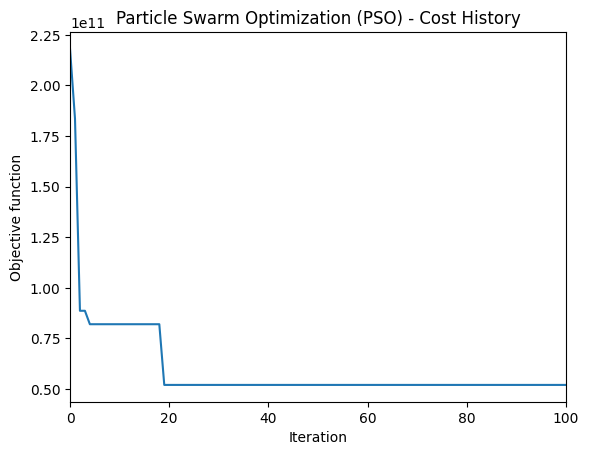

In [268]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

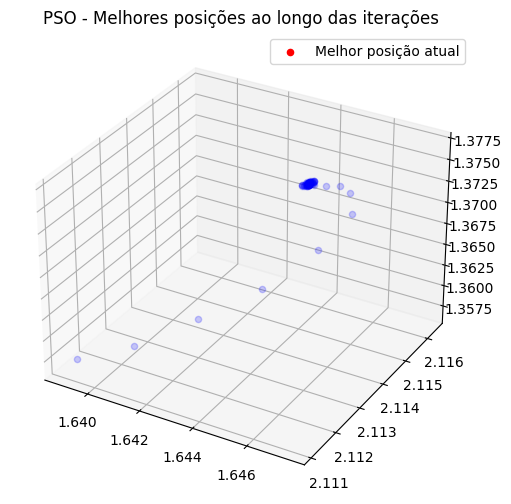

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 257014873412.59818


In [271]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])